# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

В данном проекте я оцениваю выгоду от внедрения новой функциональности в сервис бронирования. Данная функциональность оценивает, насколько большая вероятность, что данный клиент отменит заказ и на основе этого предлагает внести предоплату за бронирование. 

По ходу проекта я вначале загружаю данные, который уже предварительно разбиты на обучающую и валидационную выборки. Далее я исследую и обрабатываю данные. Я оцениваю прибыль отеля без введения новой функциональности. После этого я обучаю модель классификации и оцениваю прибыль, которую принесёт введение данноё новой функциональности за год. 

В финальной части проекта я рассматриваю, какие признаки характерны для клиента, который с большой вероятностью отменит бронирование.

Основные выводы проекта: нововведение позволяет существенно увеличить прибыль и за тестовый период окупает свой бюджет на разработку в среднем в 30 раз, но только если предположить, что клиенты, которые и так собирались приехать, не будут отрицательно реагировать на запрос депозита. 

### Шаг 1. Откройте файлы с данными

In [1]:
pip install -U ydata-profiling

     |████████████████████████████████| 352 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 460 kB 20.0 MB/s eta 0:00:01
     |████████████████████████████████| 102 kB 62.6 MB/s eta 0:00:01
     |████████████████████████████████| 296 kB 71.0 MB/s eta 0:00:01
     |████████████████████████████████| 679 kB 73.2 MB/s eta 0:00:01
     |████████████████████████████████| 6.9 MB 89.6 MB/s eta 0:00:01
     |████████████████████████████████| 4.7 MB 59.9 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 71.1 MB/s eta 0:00:01
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27085 sha256=d1916b183ebb6cb5992cfa85aad042e064fb95e81245fa2621e246b75d72260a
  Stored in directory: /home/jovyan/.cache/pip/wheels/1d/05/04/c6d7d3b66539d9e659ac6dfe81e2d0fd4c1a8316cc5a403300
Successfully built htmlmin
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade Pillow

     |████████████████████████████████| 3.4 MB 1.0 MB/s eta 0:00:01
  Attempting uninstall: Pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pillow-8.4.0
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade matplotlib

     |████████████████████████████████| 11.6 MB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 300 kB 80.9 MB/s eta 0:00:01
     |████████████████████████████████| 4.4 MB 72.4 MB/s eta 0:00:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.4
    Uninstalling matplotlib-3.3.4:
      Successfully uninstalled matplotlib-3.3.4
Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install scikit-learn==1.1.3

     |████████████████████████████████| 30.8 MB 1.9 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [5]:
pip install shap

     |████████████████████████████████| 547 kB 1.0 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
!pip install optuna

     |████████████████████████████████| 390 kB 1.1 MB/s eta 0:00:01


In [7]:
!pip install imblearn

     |████████████████████████████████| 235 kB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 26.4 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0


In [155]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from ydata_profiling import ProfileReport
from datetime import timedelta
from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, OrdinalEncoder
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import recall_score
import shap

import optuna
from optuna.samplers import TPESampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as Pipeline_imb
from imblearn.over_sampling import SMOTE, ADASYN
from catboost import CatBoostClassifier, Pool
import lightgbm as lgb

In [9]:
# Импортируем данные
path_train = 'https://code.s3.yandex.net/datasets/hotel_train.csv'
path_test = 'https://code.s3.yandex.net/datasets/hotel_test.csv'

if os.path.exists(path_train):
    data_train = pd.read_csv('https://code.s3.yandex.net/datasets/hotel_train.csv')
else:
    data_train = pd.read_csv('/datasets/hotel_train.csv')
    
if os.path.exists(path_test):
    data_test = pd.read_csv('https://code.s3.yandex.net/datasets/hotel_test.csv')
else:
    data_test = pd.read_csv('/datasets/hotel_test.csv')

Посмотрим на данные.

In [10]:
display(data_train.head())
data_test.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7


Данные загрузились корректно.

В данном разделе я загрузила данные обучающей и тренировочной выборки. 

### Шаг 2. Предобработка и исследовательский анализ данных

Посмотрим на данные в обучающей и тестовой выборке.

Описания переменных из тех задания:

•	id — номер записи;

•	adults — количество взрослых постояльцев;

•	arrival_date_year — год заезда;

•	arrival_date_month — месяц заезда;

•	arrival_date_week_number — неделя заезда;

•	arrival_date_day_of_month — день заезда;

•	babies — количество младенцев;

•	booking_changes — количество изменений параметров заказа;

•	children — количество детей от 3 до 14 лет;

•	country — гражданство постояльца;

•	customer_type — тип заказчика: (Contract — договор с юридическим лицом; Group — групповой заезд; Transient — не связано с договором или групповым заездом; Transient-party — не связано с договором или групповым заездом, но связано с бронированием типа Transient.

•	days_in_waiting_list — сколько дней заказ ожидал подтверждения;
•	distribution_channel — канал дистрибуции заказа;

•	is_canceled — отмена заказа; 

•	is_repeated_guest — признак того, что гость бронирует номер второй раз;

•	lead_time — количество дней между датой бронирования и датой прибытия;

•	meal — опции заказа: (SC — нет дополнительных опций; BB — включён завтрак; HB — включён завтрак и обед; FB — включён завтрак, обед и ужин.

•	previous_bookings_not_canceled — количество подтверждённых заказов у клиента;

•	previous_cancellations — количество отменённых заказов у клиента;
•	required_car_parking_spaces — необходимость места для автомобиля;

•	reserved_room_type — тип забронированной комнаты;

•	stays_in_weekend_nights — количество ночей в выходные дни;

•	stays_in_week_nights — количество ночей в будние дни;

•	total_nights — общее количество ночей;

•	total_of_special_requests — количество специальных отметок.

In [11]:
display(data_train.info())
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

Мы видим, что в данных нет пропусков. Посмотрим на некоторые переменные поподробнее.

Посмотрим, есть ли дубликаты.

In [12]:
display(data_train.duplicated().mean())
data_test.duplicated().mean()

0.0

0.0

Полных дубликатов нет.

Удалим id из данных, это нам не понадобится для нашей задачи.

In [13]:
def del_column(data, col):
    data=data.drop(col, axis=1)
    return data

In [14]:
data_train = del_column(data_train, 'id')
data_test = del_column(data_test, 'id')

Посмотрим на отчеты по данным в выборках.

In [15]:
# Создаю репорты
profile_train = ProfileReport(data_train, title="Train", minimal=True)
profile_test = ProfileReport(data_test, title="Test", minimal=True)

In [16]:
# Репорт для обучающей выборки
profile_train.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
# Репорт для тестовой выборки
profile_test.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

На основании репортом мы сразу видим некоторые закономерности в наших данных. Во-первых, наши классы не сбалансированы и лишь треть от клиентов отменили бронь. Причём данная пропорция сохраняется как в обучающей, так и в тестовой выборке. Мы будем адресовать дисбаланс классов на этапе обучения модели в следующих разделах. 

Некоторые переменные представлены в формате float, хотя по логике они должны быть целочисленными. Переведём их в int.

In [17]:
def to_int(data, l):
    for i in l:
        data[l] = data[l].astype(int)
        return data

In [18]:
data_train = to_int(data_train, ['lead_time', 'adults', 'children', 'babies'])
data_test = to_int(data_test, ['lead_time', 'adults', 'children', 'babies'])

У нас в данных есть stays_in_weekend_nights, stays_in_week_nights и total_nights. Первые две переменные должны суммироваться к третьей. Во-первых, я проверю, что это дейтствительно так для всех данных. Во-вторых, я удалю одну из переменных, потому что они линейно зависимы и достаточно лишь двух из трёх.

In [19]:
# Срез данных
display(data_train.query('stays_in_weekend_nights+stays_in_week_nights!=total_nights'))
data_test.query('stays_in_weekend_nights+stays_in_week_nights!=total_nights')

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights


,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights


Всё в порядке, данные адекватные. Удалю stays_in_week_nights.

In [20]:
# удаляю признак
data_train = del_column(data_train, 'stays_in_week_nights')
data_test = del_column(data_test, 'stays_in_week_nights')

У нас есть данные про год, месяц, день и неделю приезда. В этих данных неделя лишняя, потому что по году, месяцу и дню можно полностью восстановить дату и допольнительное знание о том, какая это неделя года ничего не даёт. Я удаля признак arrival_date_week_number.

In [21]:
# удаляю признак
data_train = del_column(data_train, 'arrival_date_week_number')
data_test = del_column(data_test, 'arrival_date_week_number')

Теперь посмотрю на категориальные признаки.

In [22]:
category = ['arrival_date_month', 'meal', 'country', 'distribution_channel', 'reserved_room_type', 'customer_type']

In [23]:
for cat in category:
    display(data_train[cat].unique())
    display(data_test[cat].unique())

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August'], dtype=object)

array(['BB       ', 'FB       ', 'HB       ', 'SC       ', 'SC'],
      dtype=object)

array(['BB       ', 'HB       ', 'SC', 'FB       ', 'SC       '],
      dtype=object)

array(['GBR', 'PRT', 'ESP', 'IRL', 'FRA', 'ROU', 'NOR', 'USA', 'DEU',
       'BEL', 'CHE', 'CN', 'GRC', 'NLD', 'ARG', 'RUS', 'SWE', 'POL',
       'EST', 'CZE', 'ITA', 'FIN', 'DNK', 'MOZ', 'BWA', 'LUX', 'BRA',
       'SVN', 'ALB', 'CHN', 'MEX', 'MAR', 'SMR', 'LVA', 'CHL', 'AUT',
       'LTU', 'TUR', 'ISR', 'IND', 'CYM', 'AUS', 'CPV', 'ZWE', 'DZA',
       'KOR', 'CRI', 'HUN', 'TUN', 'ARE', 'HRV', 'HKG', 'IRN', 'GIB',
       'JEY', 'URY', 'ZAF', 'COL', 'GGY', 'KWT', 'CYP', 'KAZ', 'THA',
       'DOM', 'NGA', 'BLR', 'VEN', 'UKR', 'ARM', 'JPN', 'LKA', 'MYS',
       'BIH', 'MUS', 'OMN', 'SUR', 'JAM', 'BGR', 'CIV', 'SRB', 'JOR',
       'SYR', 'PHL', 'PRI', 'SGP', 'BDI', 'LBN', 'AGO', 'VNM', 'AZE',
       'PLW', 'NZL', 'EGY', 'MDV', 'CMR', 'MLT', 'SVK', 'MWI', 'STP',
       'TWN', 'IDN', 'SEN', 'PER', 'SAU', 'KNA', 'ETH', 'ECU', 'IRQ',
       'AND', 'HND', 'PAK', 'GEO', 'ZMB', 'QAT', 'KHM', 'MCO', 'BGD',
       'ISL', 'UZB', 'IMN', 'TJK', 'NIC', 'BEN', 'MAC', 'VGB', 'TZA',
       'GAB', 'MKD', 

array(['PRT', 'AUT', 'BEL', 'DEU', 'BRA', 'GBR', 'ESP', 'FRA', 'ITA',
       'LUX', 'CHE', 'EST', 'NGA', 'IRL', 'CN', 'POL', 'AUS', 'NLD',
       'KOR', 'ROU', 'USA', 'CHL', 'DNK', 'FIN', 'RUS', 'SWE', 'HUN',
       'HRV', 'MDV', 'ZAF', 'ISR', 'NOR', 'CHN', 'ARE', 'MAR', 'COL',
       'FJI', 'LVA', 'LBN', 'PHL', 'HKG', 'SYC', 'GIB', 'AGO', 'MYS',
       'MDG', 'IDN', 'LTU', 'ISL', 'TUR', 'ARG', 'JPN', 'SVN', 'SVK',
       'BGR', 'CAF', 'JAM', 'UZB', 'UKR', 'IND', 'CZE', 'URY', 'NZL',
       'NPL', 'SRB', 'CPV', 'IRN', 'KAZ', 'BHS', 'SUR', 'CUB', 'PAK',
       'MAC', 'CYP', 'JOR', 'GRC', 'KWT', 'TWN', 'VNM', 'SGP', 'DOM',
       'VEN', 'SEN', 'BLR', 'TZA', 'LIE', 'GNB', 'SAU', 'DZA', 'PER',
       'AZE', 'EGY', 'ETH', 'KEN', 'THA', 'MLT', 'ECU', 'AND', 'IMN',
       'BHR', 'TUN', 'MNE', 'MEX', 'BEN', 'MOZ', 'UMI', 'JEY', 'MYT',
       'QAT', 'BGD', 'GAB', 'CIV', 'ZWE', 'GTM', 'ALB', 'GHA', 'ATA',
       'ASM', 'PAN', 'CRI', 'MCO', 'MUS', 'SYR', 'TGO', 'IRQ', 'LKA',
       'BIH', 'PRY', 

array(['Direct', 'TA/TO', 'Corporate', 'GDS'], dtype=object)

array(['TA/TO', 'Direct', 'Corporate', 'GDS'], dtype=object)

array(['A               ', 'C               ', 'D               ',
       'E               ', 'G               ', 'F               ',
       'B               '], dtype=object)

array(['A               ', 'E               ', 'G               ',
       'D               ', 'F               ', 'C               ',
       'B               '], dtype=object)

array(['Transient', 'Contract', 'Transient-Party', 'Group'], dtype=object)

array(['Transient', 'Transient-Party', 'Contract', 'Group'], dtype=object)

В значениях некоторых переменных есть лишние пробелы. Уберём их. 

In [24]:
for cat in category:
    data_train[cat] = data_train[cat].str.strip()
    data_test[cat] = data_test[cat].str.strip()

Посмотрим, появились ли полные дубликаты в данных после удаления id.

In [25]:
display(data_train.duplicated().mean())
data_test.duplicated().mean()

0.3277223320915544

0.23809083055658398

После удаление id, в данных оказалось от 20 до 30 процентов полных дубликатов. Это очень большой процент и удаление такого большома объёма данных может не оправданным. В наших данных нет больше никаких идентификаторов, поэтому теоретически такие дубликаты могут быть всё равно получены от разных бронирований. Я оставлю эти данные, но это может быть направлением дальнейшего исследования для улучшения модели. Для этого надо будет обратиться к источнику данных.

Посмотрим, нет ли у нас в данных бронирований без взрослых.

In [26]:
display(data_train.query('adults==0')['adults'].count())
data_test.query('adults==0')['adults'].count()

166

69

В наших данных есть некоторые бронирования без взрослых. Хотя теоретически можно представить, что это бронирование для детской поездки, но более вероятно, что эти данные аномальные и лучше их удалить.

In [27]:
data_train = data_train.query('adults>0').reset_index(drop=True)
data_test = data_test.query('adults>0').reset_index(drop=True)

У нас есть признаки is repeated guest, previous cancellations и previous bookings not cancelled. Проверим, есть ли бывшие клиенты, к которых нет ни предыдущих отмени ни подтвёржденных предыдущих заказов.

In [34]:
(
    display(data_train.query('is_repeated_guest==1 and previous_cancellations==0 and previous_bookings_not_canceled==0')
    ['adults'].count()))
data_test.query('is_repeated_guest==1 and previous_cancellations==0 and previous_bookings_not_canceled==0')['adults'].count()

155

88

In [36]:
display(data_train.shape)
data_test.shape

(65063, 22)

(32343, 22)

Оказывается, есть наблюдения, в которых посетители ранее уже были клиентами, но при этом у них нет ни предыдущих отмен ни предыдущих визитов. Похоже, что в этих данных тоже ошибка, поэтому я их удалю. 

In [40]:
data_train = (
    data_train
    .drop(data_train.query('is_repeated_guest==1 and previous_cancellations==0 and previous_bookings_not_canceled==0').index)
    .reset_index(drop=True))
data_test = (
    data_test
    .drop(data_test.query('is_repeated_guest==1 and previous_cancellations==0 and previous_bookings_not_canceled==0').index)
    .reset_index(drop=True))

Когда клиент бронирует номер, у отеля уже могут быть более ранние брони на эти же даты. Колличество таких броней может быть характеристикой популярности определённых дат в отеле и являться хорошей прокси для спроса на номера отеля в определённые даты.

В оставшемся датасете всё равно эти три переменные должны быть сильно скоррелированы чисто по конструкции, поэтому я осталю лишь две из них и удалю is_repeated_guest. 

In [47]:
data_train = del_column(data_train, 'is_repeated_guest')
data_test = del_column(data_test, 'is_repeated_guest')

Для того, чтобы посчитать колличествно ранее забронированных номеров на данные даты, я восстановлю дату бронирования, дату заезда и дату выезда. Для этого вначале мне нужно преобразовать дату заезда в переменную типа datetime.

In [49]:
data_train['arrival_date'] = (
    pd.to_datetime(data_train['arrival_date_year'].astype(str) 
                   + data_train['arrival_date_month'] + data_train['arrival_date_day_of_month'].astype(str), format='%Y%B%d')
)

data_test['arrival_date'] = (
    pd.to_datetime(data_test['arrival_date_year'].astype(str) 
                   + data_test['arrival_date_month'] + data_test['arrival_date_day_of_month'].astype(str), format='%Y%B%d')
)

Теперь восстановлю дату вызда.

In [50]:
data_train['check_out_date'] = data_train['arrival_date'] + pd.to_timedelta(data_train['total_nights'], unit='d')
data_test['check_out_date'] = data_test['arrival_date'] + pd.to_timedelta(data_test['total_nights'], unit='d')

Теперь я восстановлю дату бронирования.

In [51]:
data_train['booking_date'] = data_train['arrival_date'] - pd.to_timedelta(data_train['lead_time'], unit='d')
data_test['booking_date'] = data_test['arrival_date'] - pd.to_timedelta(data_test['lead_time'], unit='d')

In [52]:
# Создаю переменную с временным интервалом бронирования
data_train['stay_interval'] = [pd.Interval(a,b)  for a,b in zip(data_train['arrival_date'], data_train['check_out_date'])]

In [53]:
data_test['stay_interval'] = [pd.Interval(a,b)  for a,b in zip(data_test['arrival_date'], data_test['check_out_date'])]

Для определения колличества ранее забронированных номеров на пересекающиеся времена я буду проверять, пересекаются ли stay_interal у данного бронирования и более ренних бронирований.

In [54]:
# Функция подсчёта пересечений
def already_booked(data):
    booked=[]
    for i in data.sort_values(by='booking_date')['stay_interval'].expanding():
        current_interval = i[i.index[-1]]
        booked.append(i.apply(lambda x: current_interval.overlaps(x)).sum()-1)
    return booked

<div class="alert alert-block alert-warning">
Данная функция в следующей ячейке у меня работала около 30 минут. Я сохранила полученные данные и потом загружала их извне.  
</div>

In [55]:
# Подсчитываю ранее забронированные номера (ДОЛГО РАБОТАЕТ)

data_train['booked'] = pd.Series(already_booked(data_train), index = data_train.sort_values(by='booking_date').index)
data_test['booked'] = pd.Series(already_booked(data_test), index = data_test.sort_values(by='booking_date').index)

In [10]:
# В дальнейшем я загружала сохранённые данные, которые получила после экзекуции предыдущей ячейки
# data_train = pd.read_csv('data_train.csv')
# data_test = pd.read_csv('data_test.csv')

In [61]:
#data_train['check_out_date'] = pd.to_datetime(data_train['check_out_date'],format='%Y-%m-%d')
#data_test['check_out_date'] = pd.to_datetime(data_test['check_out_date'],format='%Y-%m-%d')
#data_train['arrival_date'] = pd.to_datetime(data_train['arrival_date'],format='%Y-%m-%d')
#data_test['arrival_date'] = pd.to_datetime(data_test['arrival_date'],format='%Y-%m-%d')
#data_train['booking_date'] = pd.to_datetime(data_train['booking_date'],format='%Y-%m-%d')
#data_test['booking_date'] = pd.to_datetime(data_test['booking_date'],format='%Y-%m-%d')

Посмотрим, как соотносится колличество уже забронированных номеров и то, насколько заранее я делаю бронирование.

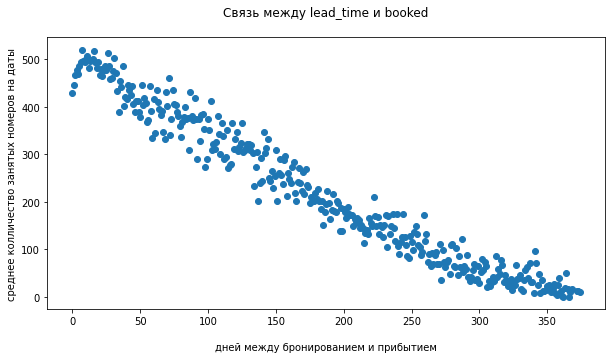

In [72]:
plt.figure(figsize = (10,5))
(
    plt.scatter(pd.concat([data_train, data_test]).groupby('lead_time')['booked'].mean().index, 
                pd.concat([data_train, data_test]).groupby('lead_time')['booked'].mean())
)
plt.xlabel('\n' 'дней между бронированием и прибытием')
plt.ylabel('среднее колличество занятых номеров на даты')
plt.title('Связь между lead_time и booked\n');

Как и кажется логичным, чем более заранее делается бронирование тем меньше занятых номеров. 

На данном шаге мы изучили наши данные. В данных нет пропусков. Мы исправили названия некоторых категориальных переменных и поменяли некоторые типы. Мы также увидели, что классы несбалансированы и это повлияет на процесс обучения моделей в следующих пунктах. Мы так же создали новую переменную, которая отражает, сколько номеров было уже забронирована на искомый период на время бронирования. Закономерно данная переменная визуально сильно отрицательно скоррелирована со временем до заезда.

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

В данном пункте мы будем рассчитывать прибыль компании без внедрении системы депозитов. В рассчёте прибыли будут использованы некоторые константы, зададим их. В тех задании было сказано, что если клиент снял номер надолго, то убираются раз в два дня. Будем считать, что долгое проживание это больше 2 дней. Тогда для любого колличества ночей можно рассчитать колличество уборок как 1+total_nights // 2. 

In [73]:
# Задаём константы
PRICES = {'A':1000, 'B': 800, 'C': 600, 'D': 550, 'E': 500, 'F': 450, 'G': 350}
COSTS = {'A': 400, 'B': 350, 'C': 350, 'D': 550, 'E': 500, 'F': 450, 'G': 350}
DEPOSIT_COEF = 0.8 #Сколько процентов от стоимости будет депозит

SEASON_COEFS = {'SPRING': 1.2, 'AUTUMN': 1.2, 'SUMMER': 1.4, 'WINTER':1}

SEASON_NUMBERS = {'SPRING': [3,4,5], 'AUTUMN': [9,10,11], 'SUMMER': [6,7,8], 'WINTER': [12, 1,2]}

BUDGET = 400000

Посмотрим, как часто люди бронировали проживание на долгое время.

Теперь посмотрим, есть ли у нас наблюдения, когда заезд был в одном сезоне, а выезд в другом. Для этого построим ещё одну переменную, которая соответесвует дате последней ночи.

In [74]:
data_train['last_night_date'] = data_train['check_out_date'] + pd.to_timedelta(-1, unit='d')
data_test['last_night_date'] = data_test['check_out_date'] + pd.to_timedelta(-1, unit='d')

In [75]:
# Функция подсчёта наблюдений
def mix_seasons_count(data, season_list):
    display((
        data_train
        .query('@data["arrival_date"].dt.month in @season_list[0] '+
               'and @data["last_night_date"].dt.month in @season_list[1] and is_canceled==0')['total_nights'].count())
    )

In [76]:
# Создаю список со смешенными сезонами
mix_season_list = (
    [[SEASON_NUMBERS['SUMMER'], SEASON_NUMBERS['AUTUMN']], 
     [SEASON_NUMBERS['AUTUMN'], SEASON_NUMBERS['WINTER']], 
     [SEASON_NUMBERS['WINTER'], SEASON_NUMBERS['SPRING']], 
     [SEASON_NUMBERS['SPRING'], SEASON_NUMBERS['SUMMER']]]
)

In [77]:
for data in [data_train, data_test]:
    for s_l in mix_season_list:
        mix_seasons_count(data, s_l)

328

130

150

223

109

0

188

115

У нас есть такие наблюдения и их тоже надо будет учесть при подсчёте прибыли.

In [79]:
# Создаю список с типами номеров
type_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [97]:
def profit(data):
    arrived = profit_arrived(data)
    cancelled = profit_cancelled(data)
    profit = arrived + cancelled
    return profit, arrived, cancelled

In [96]:
def profit_arrived(data):
    profit = profit_mix_season(data)+profit_same_season(data)
    return profit

Подсчитаем прибыль от броней, которые захватывали сразу два сезона.

Создадим переменную с последним днём месяца заезда.

In [82]:
import warnings
warnings.filterwarnings('ignore') # отключим предупреждения, чтобы не отвлекали

In [83]:
data_train['last_day_month'] = data_train['arrival_date']+pd.Series([relativedelta(day=31)]*len(data_train))
data_test['last_day_month'] = data_test['arrival_date']+pd.Series([relativedelta(day=31)]*len(data_test))

In [94]:
# Функция подсчёта прибыли от посетителей, которые застали два сезона
def profit_mix_season(data):
    profit_list = []
    for t in type_list:
        for s_l in mix_season_list:
            #Колличество дней в первом сезоне 
            count_first_half = (
                (data
                 .query('reserved_room_type==@t and @data["arrival_date"].dt.month in @s_l[0]'+ 
                        'and @data["last_night_date"].dt.month in @s_l[1] and is_canceled==0')
                 ['last_day_month']
                 - data.query('reserved_room_type==@t and @data["arrival_date"].dt.month in @s_l[0] and '+
                              '@data["last_night_date"].dt.month in @s_l[1] and is_canceled==0')
                 ['arrival_date'])
                .sum().days
            )
            #Выручка от этих дней
            revenue_first_half = (
                SEASON_COEFS[list(SEASON_NUMBERS.keys())[list(SEASON_NUMBERS.values()).index(s_l[0])]]*PRICES[t]
                *count_first_half
            )
            # Колличество дней во втором сезоне
            count_second_half = (
                data
                .query('reserved_room_type==@t and @data["arrival_date"].dt.month in @s_l[0]'+
                       'and @data["last_night_date"].dt.month in @s_l[1] and is_canceled==0')
                ['total_nights'].sum() - count_first_half
            )
            #Выручка от дней во втором сезоне
            revenue_second_half = (
                SEASON_COEFS[list(SEASON_NUMBERS.keys())[list(SEASON_NUMBERS.values()).index(s_l[1])]]*PRICES[t]
                *count_second_half
            )
            # Суммарная прибыль для коротких визитов
            profit = revenue_first_half + revenue_second_half - COSTS[t]*(1 + (count_first_half + count_second_half)//2)
            
            
            profit_list.append(profit)
            
    # Общая прибыль от броней, которые застали два сезона        
    return sum(profit_list)

Теперь подсчитаем прибыль от тех бронирований, которые были внутри одного сезона.

In [99]:
def profit_same_season(data):
    profit_list=[]
    for t in type_list:
        for s in SEASON_NUMBERS.values():
            # Число ночей
            count = (
                data
                .query('reserved_room_type==@t and @data["arrival_date"].dt.month in @s '+
                       'and is_canceled==0')['total_nights'].sum()
            )
            # Прибыль
            profit = (
                SEASON_COEFS[list(SEASON_NUMBERS.keys())[list(SEASON_NUMBERS.values()).index(s)]]*PRICES[t]*count 
                - COSTS[t]*(1 + count//2)
            )
            profit_list.append(profit)
                
    return sum(profit_list)

Теперь подсчитаем отрицательную прибыль (убыток) от тех, кто отменил бронирование.

In [91]:
def profit_cancelled(data):
    loss = []
    for t in type_list:
        for s in SEASON_NUMBERS.values():
            # Считаем колличество отмененённых броней
            count = (
                data
                .query('reserved_room_type==@t and '+
                       ' @data["arrival_date"].dt.month in @s and is_canceled==1')['total_nights'].count()
            )
            # Считаем убыток
            profit = (
                -(SEASON_COEFS[list(SEASON_NUMBERS.keys())[list(SEASON_NUMBERS.values()).index(s)]]*PRICES[t] + COSTS[t])*count
            )
            loss.append(profit)
    return sum(loss)

Теперь подсчитаем прибыль отеля за период данных обучающей выборки и за период тестовой выборки.

In [101]:
profit_train, profit_arrived_train, loss_cancelled_train = profit(data_train)

In [102]:
display(round(profit_train))
display(round(profit_arrived_train))
round(loss_cancelled_train)

70796600

107851150

-37054550

За период обучающей выборки отель заработал около 71 млн. При этом от клиентов, которые заехали прибыль была почти что 108 млн, но от незаехавших клиентов было практически 37 млн убытков. Как видно, есть потенциал для введения новой функциональности, потому чтои убыток от отменённых бронирований довольно большой.

По условию тех задания, новая функциональность должна окупиться за тестовый период, то есть за временной промежуток тестовой выборки. Посмотрим, какая прибыль на тестовой выборке сейчас без новой функциональности.

In [103]:
profit_test_before, profit_arrived_test_before, loss_cancelled_test_before = profit(data_test)

In [104]:
display(round(profit_test_before))
display(round(profit_arrived_test_before))
round(loss_cancelled_test_before)

33926120

53043340

-19117220

За тестовый период без новой опции прибыль 34 миллиона, при этом убыток от отменённых бронирований был около 19 млн.

В данном разделе я построила функции подсчёта прибыли отеля. Оказалось, что где-то половину заработенной прибыли отель теряет из-за убытков от клиентов, которые отменили бронирование. Предварительный анализ показывает, что действительно возможность требовать депозит может быть оправданной.

### Шаг 4. Разработка модели ML

В нашей выборке есть дисбаланс классов как мы видели, поэтому мы будем в процессе обучение рассматривать разные способы борьбы с дисбалансом классов. 

In [105]:
data_train['is_canceled'].value_counts(True)

0    0.630739
1    0.369261
Name: is_canceled, dtype: float64

Для нас важнее определить правильно того, кто в будущем отменит бронирование, и не очень страшно, если с человека, который в будущем приедет, мы попросим депозит, наша метрика будет recall.

#### Первичная подготовка features and targets

Перед тем, как начать рассматривать основные виды моделей и способов борьбы с дисбалансом классов, я хочу отобрать самые важные фичи и также применить feature-engineering. Для отборки наиболее важных фичей, я добавлю в переменные случайную величину и оставлю только те фичи, которые влияют на зависимую переенную больше, чем случайный признак.

Создадим features и targets.

In [106]:
def get_features(data):
    features = (
        data
        .drop(['is_canceled', 'arrival_date', 'check_out_date', 'booking_date', 'stay_interval', 
                'last_night_date', 'last_day_month'], axis=1)
    )
    return features

In [108]:
def get_target(data):
    target = data['is_canceled']
    return target

In [109]:
features_train = get_features(data_train)
features_test = get_features(data_test)
target_train = get_target(data_train)
target_test = get_target(data_test)

In [110]:
# Создаю случайную переменную
features_train['random'] = np.random.uniform(0,1,len(features_train))

In [138]:
categorical = ['arrival_date_month', 'meal', 'country', 'distribution_channel', 'reserved_room_type', 'customer_type']
numerical = (
    ['lead_time', 'arrival_date_year', 'arrival_date_day_of_month', 'adults', 'children', 'babies', 
     'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 
     'required_car_parking_spaces', 'total_of_special_requests', 'total_nights', 'booked', 'random']
)

<div class="alert alert-warning">
<h2>Комментарий ревьюера<a class="tocSkip"></a></h2>
    
**Есть совет** ⚠️: вообще для «деревянных» моделей лучше использовать порядковое кодирование, так как они заметно быстрее обучаются на меньшем количестве признаков и не теряют в качестве, есть <a href="https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931" target="blank_">шикарная статья</a> на эту тему. Но для линейных моделей(в том числе логистической регрессии) порядковое кодирование не подходит, потому что задает приоритет признакам, которого в природе данных нет. Тогда, например, значение 10^2 в признаке X для них будет важнее, чем значение 10^1, а это далеко не всегда верное утверждение. Поэтому для них лучше использовать OHE.
    
Также для «деревянных» моделей масштабирование совсем не обязательно, <a href="https://towardsdatascience.com/how-data-normalization-affects-your-random-forest-algorithm-fbc6753b4ddf" target="blank_">тут</a> можно почитать про это подробнее. Но для линейных моделей наоборот, может заметно улучшить метрики
    
Тогда у тебя получится разная предобработка для разных моделей, это вполне нормально :)</div>

#### Feature selection

Я хочу отобрать те признаки, которые действительно важны для решения об отмене брони. Для этого я буду смотреть на вектор Шепли и сравнивать влияние признаков с влиянием случайного признака. 

In [122]:
model = CatBoostClassifier(iterations=300, random_seed=42)

In [124]:
model.fit(features_train, target_train, cat_features=categorical, verbose=False, plot=False)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

In [125]:
explainer = shap.TreeExplainer(model)

In [129]:
shap_values = explainer.shap_values(Pool(features_train, target_train, cat_features=categorical))

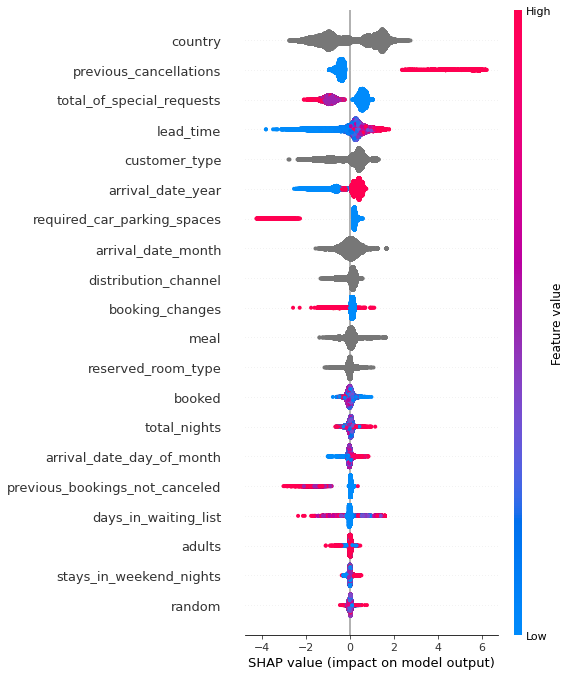

In [130]:
shap.summary_plot(shap_values, features_train)

Как мы видим из графика некоторые переменные очень сильно влияют на вероятность отмены (страна, previous_cancellations). И ни одна переменная не имеет меньшего влияния, что наша искуственная переменная. 

In [131]:
features_train = del_column(features_train, 'random')

In [139]:
numerical = (
    ['lead_time', 'arrival_date_year', 'arrival_date_day_of_month', 'adults', 'children', 'babies', 
     'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 
     'required_car_parking_spaces', 'total_of_special_requests', 'total_nights', 'booked']
)

#### Выбор модели

Мы будем исследовать несколько способов борьбы с дисбалансом и выбирать из трёх видов классификаторов.

In [182]:
def objective(trial):
    samplers = trial.suggest_categorical("samplers", ['undersample', 'SMOTE', 'ADASYN'])
    if samplers=='undersample':
        sample = RandomUnderSampler(random_state=42)
    elif samplers=='SMOTE':
        sample = SMOTE(random_state=42)
    else:
        sample = ADASYN(random_state=42)
    
    classifier_name = trial.suggest_categorical("classifier", ["Tree", "Forest", "Logistic_Regression", "Light"])
    
    
    if classifier_name == "Tree":
        dt_md = trial.suggest_int('max_depth', 2, 20)
        dt_sl = trial.suggest_int('min_inst', 1, 32)
        categorical_transformer = Pipeline(steps=[('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])
        numeric_transformer = Pipeline(steps=[('polinomial', PolynomialFeatures(2))])
        classifier_obj = DecisionTreeClassifier(max_depth=dt_md, min_samples_leaf=dt_sl, random_state=42 )
        
    elif classifier_name == 'Forest':
        rf_md = trial.suggest_int("rf_md", 2, 25, log=True)
        rf_n_estimators = trial.suggest_int('rf_num_estimators', 5, 100) 
        categorical_transformer = Pipeline(steps=[('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])
        numeric_transformer = Pipeline(steps=[('polinomial', PolynomialFeatures(2))])
        classifier_obj = RandomForestClassifier(max_depth=rf_md, n_estimators=rf_n_estimators)
        
    elif classifier_name == 'Light':
        light_nl = trial.suggest_int("num_leaves", 2, 256)
        categorical_transformer = Pipeline(steps=[('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])
        numeric_transformer = Pipeline(steps=[('polinomial', PolynomialFeatures(2))])
        classifier_obj = lgb.LGBMClassifier(num_leaves=light_nl)
        
    else:
        logreg_s = trial.suggest_categorical('solver' , ['lbfgs','liblinear'])
        numeric_transformer = Pipeline(steps=[('scaler', StandardScaler()), ('polinomial', PolynomialFeatures(2))])
        categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))])
        classifier_obj = LogisticRegression(solver=logreg_s)
    
    preprocessor = (
    make_column_transformer((numeric_transformer, numerical),(categorical_transformer, categorical), 
                            remainder='passthrough',
                            verbose_feature_names_out=False))
    pipeline = Pipeline_imb([('preprocessor',preprocessor),('sample',sample), ('estimation',classifier_obj)])
    
    score = cross_val_score(pipeline, features_train, target_train, scoring='recall')
    recall_mean = score.mean() 
    return recall_mean

In [184]:
sampler = TPESampler(seed=42)
study = optuna.create_study(sampler=sampler, direction="maximize") 
study.enqueue_trial({'samplers': 'undersample','classifier': 'Tree', 'max_depth': 4,'min_inst': 28})
study.optimize(objective, n_trials=30)

[I 2023-07-18 18:05:22,084] A new study created in memory with name: no-name-95064529-e3e6-4826-8e8d-d28860eac0bd
[I 2023-07-18 18:05:25,190] Trial 0 finished with value: 0.6232550929290308 and parameters: {'samplers': 'undersample', 'classifier': 'Tree', 'max_depth': 4, 'min_inst': 28}. Best is trial 0 with value: 0.6232550929290308.
[I 2023-07-18 18:05:54,077] Trial 1 finished with value: 0.5325943889281589 and parameters: {'samplers': 'SMOTE', 'classifier': 'Tree', 'max_depth': 18, 'min_inst': 20}. Best is trial 0 with value: 0.6232550929290308.
[I 2023-07-18 18:07:05,646] Trial 2 finished with value: 0.6515408587182271 and parameters: {'samplers': 'ADASYN', 'classifier': 'Tree', 'max_depth': 7, 'min_inst': 17}. Best is trial 2 with value: 0.6515408587182271.
[I 2023-07-18 18:10:24,591] Trial 3 finished with value: 0.49433966287750497 and parameters: {'samplers': 'ADASYN', 'classifier': 'Light', 'num_leaves': 202}. Best is trial 2 with value: 0.6515408587182271.
[I 2023-07-18 18:12:

Сохраним лучший трайл.

In [185]:
trial = study.best_trial
trial

FrozenTrial(number=29, state=TrialState.COMPLETE, values=[0.7308520430425368], datetime_start=datetime.datetime(2023, 7, 18, 18, 47, 52, 235990), datetime_complete=datetime.datetime(2023, 7, 18, 18, 49, 2, 217666), params={'samplers': 'ADASYN', 'classifier': 'Forest', 'rf_md': 3, 'rf_num_estimators': 28}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'samplers': CategoricalDistribution(choices=('undersample', 'SMOTE', 'ADASYN')), 'classifier': CategoricalDistribution(choices=('Tree', 'Forest', 'Logistic_Regression', 'Light')), 'rf_md': IntDistribution(high=25, log=True, low=2, step=1), 'rf_num_estimators': IntDistribution(high=100, log=False, low=5, step=1)}, trial_id=29, value=None)

In [186]:
# Параметр модели
trial.params 

{'samplers': 'ADASYN',
 'classifier': 'Forest',
 'rf_md': 3,
 'rf_num_estimators': 28}

Лучшая модель это модель случайного леса глубиной 3 из 28 деревьев и предварительным апсамплингом. У данной модели получился средний recall при кроссвалидации 0.7308520430425368.

#### Обучаем лучшую модель

In [187]:
best_model = RandomForestClassifier(max_depth=3, n_estimators=28, random_state=42 )

In [188]:
sampler = ADASYN(random_state=42)

In [189]:
categorical_transformer = Pipeline(steps=[('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])
numeric_transformer = Pipeline(steps=[('polinomial', PolynomialFeatures(2))])
preprocessor = (
    make_column_transformer((numeric_transformer, numerical),(categorical_transformer, categorical), 
                            remainder='passthrough',
                            verbose_feature_names_out=False))

In [190]:
pipeline = Pipeline_imb([('preprocessor',preprocessor),('sample',sampler), ('estimation', best_model)])

In [191]:
pipeline.fit(features_train, target_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('polinomial',
                                                                   PolynomialFeatures())]),
                                                  ['lead_time',
                                                   'arrival_date_year',
                                                   'arrival_date_day_of_month',
                                                   'adults', 'children',
                                                   'babies',
                                                   'previous_cancellations',
                                                   'previous_bookings_not_canceled',
                                                   'booking_changes',
                                                   'days_in_waiting_list',
                                                   'requ...
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['arrival_date_month', 'meal',
                                                   'country',
                                                   'distribution_channel',
                                                   'reserved_room_type',
                                                   'customer_type'])],
                                   verbose_feature_names_out=False)),
                ('sample', ADASYN(random_state=42)),
                ('estimation',
                 RandomForestClassifier(max_depth=3, n_estimators=28,
                                        random_state=42))])

Проверим результативность нашей модели на тестовой выборке

In [192]:
predictions = pipeline.predict(features_test)

In [193]:
recall_test = recall_score(target_test, predictions)
recall_test

0.6286328529341508

На тестовой выборке удалось получить метрику полноты  0.63, что меньше, чем метрика при кросс-валидации на обучающей.

Мы обучили модель, кототорую отобрали с помощью оптимизации и получили предсказания для тестовой выборки.Теперь с помощью этих предсказаний мы будем оценивать распределение прибыли на тестовой выборке. 

Для начала мы рассчитаем прибыль от введения новой функциональности.

#### Прибыль от введения депозитов

Создадим функцию подсчёта прибыли после введения системы депозитов.

In [194]:
# Функция подсчёта прибыли после введения депозитов
def profit_deposit(data):
    data_cancelled = data.query('is_canceled==1 and predictions==0')
    data_deposit = data.query('is_canceled==1 and predictions==1')
    
    arrived = profit_arrived(data)
    
    cancelled = profit_cancelled(data_cancelled) + profit_payed_deposit(data_deposit)
    
    profit = arrived+cancelled
    
    return profit, arrived, cancelled

In [196]:
# Прибыль от тех, кто отменил, но заплатил депозит
def profit_payed_deposit(data):
    loss = []
    for t in type_list:
        for s in SEASON_NUMBERS.values():
            # Считаем колличество отмененённых броней
            count = (
                data
                .query('reserved_room_type==@t and '+
                       ' @data["arrival_date"].dt.month in @s and is_canceled==1')['total_nights'].count()
            )
            # Считаем убыток
            profit = ((DEPOSIT_COEF-1)*SEASON_COEFS[list(SEASON_NUMBERS.keys())[list(SEASON_NUMBERS.values()).index(s)]]
                 *PRICES[t]*count - COSTS[t]*(1 + count//2)
            )
            loss.append(profit)
    return sum(loss)

In [197]:
# Задаю случайный стэйт
state = np.random.RandomState(12345)

In [198]:
# Функция подсчёта распределения прибыли
def profit_distribution(predictions, data):
    values_profit = []
    values_arrived = []
    values_cancelled = []
    for i in range(30):
        data = pd.concat([data, pd.Series(predictions, name='predictions')], axis=1)
        data_sample = data.sample(random_state=state, frac=1, replace=True)
        profit_sample, arrived_sample, cancelled_sample = profit_deposit(data_sample)
        values_profit.append(profit_sample)
        values_arrived.append(arrived_sample)
        values_cancelled.append(cancelled_sample)
    distribution_profit = pd.Series(values_profit)
    distribution_arrived = pd.Series(values_arrived)
    distribution_cancelled = pd.Series(values_cancelled)
    profit_mean = distribution_profit.mean()
    arrived_mean = distribution_arrived.mean()
    cancelled_mean = distribution_cancelled.mean()
    lower = distribution_profit.quantile(0.025)
    upper = distribution_profit.quantile(0.975)
    risk = (distribution_profit<BUDGET).mean()
    return (
        distribution_profit, distribution_arrived, distribution_cancelled, profit_mean, arrived_mean, 
        cancelled_mean, lower, upper, risk
    )

Отфильтрую данные, чтобы остались только те стобцы, которые нужны для рассчёта прибыли

In [199]:
data_test_filtered = (
    data_test[['reserved_room_type', 'arrival_date', 'last_night_date', 'is_canceled', 'total_nights', 'last_day_month']]
)

In [200]:
# Получаем распределение прибыли 
# Долго работает

profit_distribution, distribution_arrived, distribution_cancelled, profit_mean, arrived_mean, cancelled_mean, lower, upper, risk = (
    profit_distribution(predictions, data_test_filtered)
)

Нарисуем распределение прибыли после введения новой функциональности, а также прибыли от заселившихся клиентов и убытков от отменивших бронирование.

In [202]:
def histogram(distribution, mean, label, title):
    fig, ax = plt.subplots()
    plt.hist(distribution/10**6, bins = 20, alpha=0.6, label=label, density=True)
    plt.axvline(x = mean/10**6, color = 'r')
    plt.xlabel('\n млн.')
    plt.legend(loc = 'upper right')
    fig.set_figwidth(12)    
    fig.set_figheight(6)    
    plt.title(title)
    plt.ticklabel_format(useOffset=False, style='plain')
    fig.set_facecolor('floralwhite')
    ax.set_facecolor('seashell')
    plt.show()  

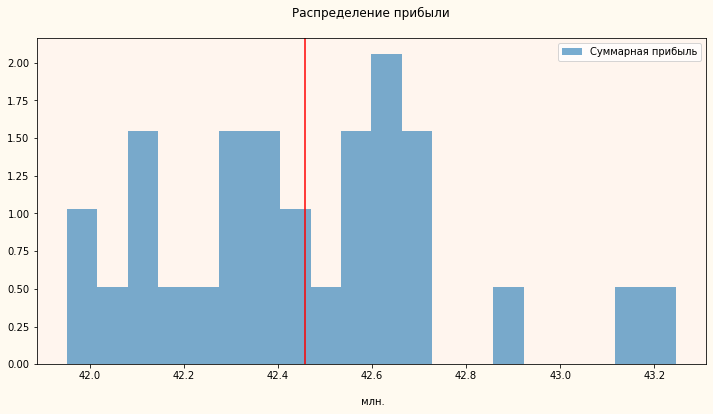

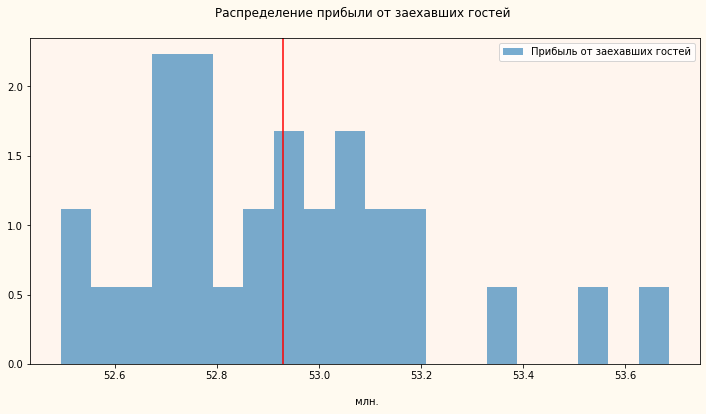

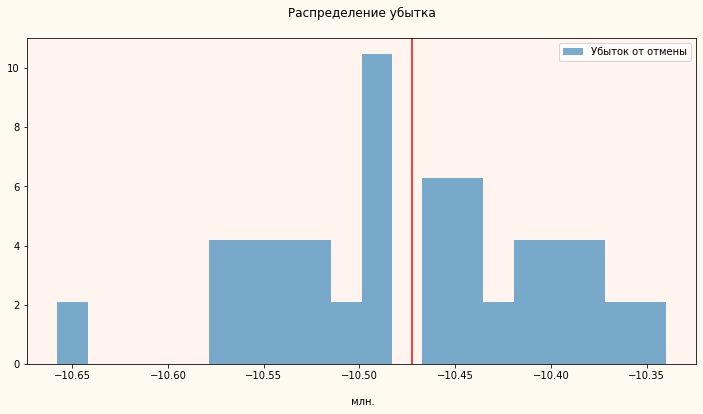

In [203]:
histogram(profit_distribution, profit_mean, 'Суммарная прибыль', 'Распределение прибыли\n')
histogram(distribution_arrived, arrived_mean, 'Прибыль от заехавших гостей', 'Распределение прибыли от заехавших гостей \n')
histogram(distribution_cancelled, cancelled_mean, 'Убыток от отмены', 'Распределение убытка\n')

На графиках мы видим, что прибыль после нововведения распределенена между 42 и 43 миллионами. При этом прибыль от заехавших гостей распеределена очень близко к значению до нововведения, что абсолютно логично, потому что нововведение не влияет на людей, которые и так бы не отменили бронирования. При этом убыток от тех, кто отменил распределён в районе 10 миллионов.

Сравним теперь значения прибыли без системы депозитов и с ней. 

In [204]:
# Таблица
result = (
    pd.DataFrame([[profit_mean/10**6, arrived_mean/10**6, cancelled_mean/10**6], 
                  [profit_test_before/10**6, profit_arrived_test_before/10**6, loss_cancelled_test_before/10**6]],
    index=['После', 'До'], 
    columns=['Прибыль, млн.', 'Прибыль от заехавших гостей, млн.', 'Убыток от отменённых бронирований, млн.']
))
(result.
 style.
 format({'Прибыль, млн.':"{:,.2f}",'Прибыль от заехавших гостей, млн.':"{:,.2f}", 'Убыток от отменённых бронирований, млн.':"{:,.2f}"})
)

,"Прибыль, млн.","Прибыль от заехавших гостей, млн.","Убыток от отменённых бронирований, млн."
После,42.46,52.93,-10.47
До,33.93,53.04,-19.12


Как мы видим, после нововведения прибыль выросла почти что на 9 миллионов за счёт уменьшения убытка от отменённых бронирований. Это покрывает бюджет на разработку в 400000. 

В данном разделе я отобрала алгоритм борьбы с дисбалансом и модель для предсказания отмены бронировния. Наилучшую метрику на кросс-валидации показала модель дерева решений глубины 3 совмещенная с алгоритмом апсамплинга. На тестовой выборке метрика recall была 0.63. Далее я построила функцию прибыли после нововведения, используя предсказания модели и бутстрапом посмотроила распределение прибыли. С помощью системы депозитов прибыль удалось увеличить практически на 9 миллионов за тестовый период, что в разы окупило бюджет на разработку. 

#### Проверка модели на worst case scenario

При выборе модели мы сейчас описались на метрика recall и считали, что если вдруг предложение заплатить депозит придёт клиенту, который и так не отменил бы бронирование, то ничего не изменится и оплата депозита просто пойдёт в счёт будущей брони. В данном разделе, я провожу эксперимент с наихудшим вариантом, когда половина клиентов, которые не собирались отменять бронирование, но при этом получили предложение заплатить депозит, будут недовольны этим и откажутся от сервиса. 

In [276]:
# Функция подсчёта прибыли после введения депозитов 
def profit_deposit_unhappy(data):
    data_cancelled = data.query('is_canceled==1 and predictions==0')
    data_deposit = data.query('is_canceled==1 and predictions==1')
    data_arrived = data.query('unhappy==0')
    
    arrived = profit_arrived(data_arrived)
    
    cancelled = profit_cancelled(data_cancelled) + profit_payed_deposit(data_deposit)
    
    profit = arrived+cancelled
    
    return profit, arrived, cancelled

In [280]:
# Функция подсчёта распределения прибыли
def profit_distribution_unhappy(predictions, data):
    values_profit = []
    values_arrived = []
    values_cancelled = []
    data = pd.concat([data, pd.Series(predictions, name='predictions')], axis=1)
    for i in range(30):
        data['unhappy'] = np.where(data['is_canceled']==0, np.where(data['predictions']==1, 1, 0), 0)
        data_sample = data.sample(random_state=state, frac=1, replace=True)
        profit_sample, arrived_sample, cancelled_sample = profit_deposit_unhappy(data_sample)
        values_profit.append(profit_sample)
        values_arrived.append(arrived_sample)
        values_cancelled.append(cancelled_sample)
    distribution_profit = pd.Series(values_profit)
    distribution_arrived = pd.Series(values_arrived)
    distribution_cancelled = pd.Series(values_cancelled)
    profit_mean = distribution_profit.mean()
    arrived_mean = distribution_arrived.mean()
    cancelled_mean = distribution_cancelled.mean()
    lower = distribution_profit.quantile(0.025)
    upper = distribution_profit.quantile(0.975)
    risk = (distribution_profit<BUDGET).mean()
    return (
        distribution_profit, distribution_arrived, distribution_cancelled, profit_mean, arrived_mean, 
        cancelled_mean
    )

In [281]:
# Получаем распределение прибыли 
# Долго работает

profit_unhappy, arrived_unhappy, cancelled_unhappy, profit_mean_u, arrived_mean_u, cancelled_mean_u = (
    profit_distribution_unhappy(predictions, data_test_filtered)
)

In [282]:
def histogram(distribution, mean, label, title):
    fig, ax = plt.subplots()
    plt.hist(distribution/10**6, bins = 20, alpha=0.6, label=label, density=True)
    plt.axvline(x = mean/10**6, color = 'r')
    plt.xlabel('\n млн.')
    plt.legend(loc = 'upper right')
    fig.set_figwidth(12)    
    fig.set_figheight(6)    
    plt.title(title)
    plt.ticklabel_format(useOffset=False, style='plain')
    fig.set_facecolor('floralwhite')
    ax.set_facecolor('seashell')
    plt.show()  

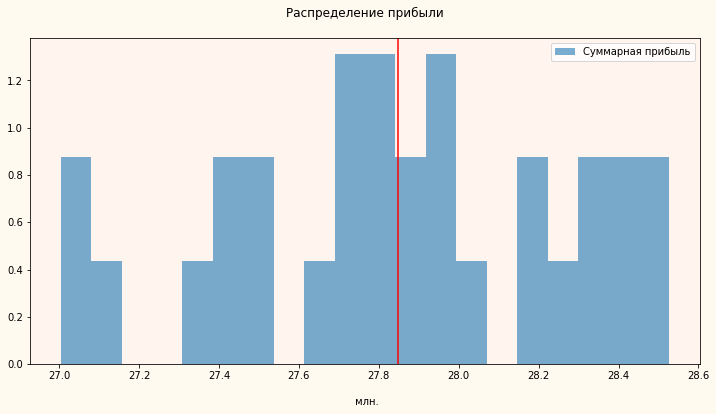

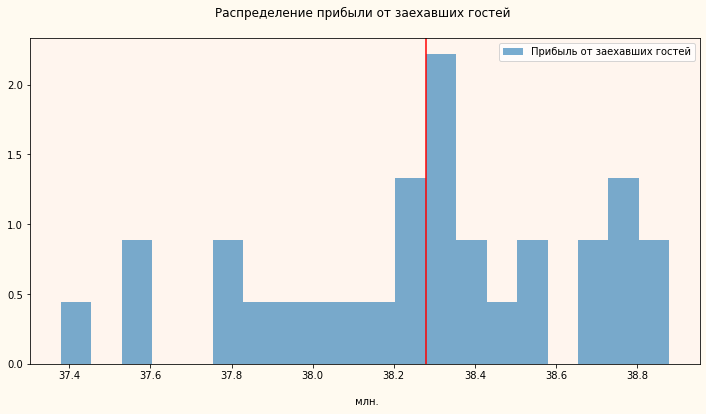

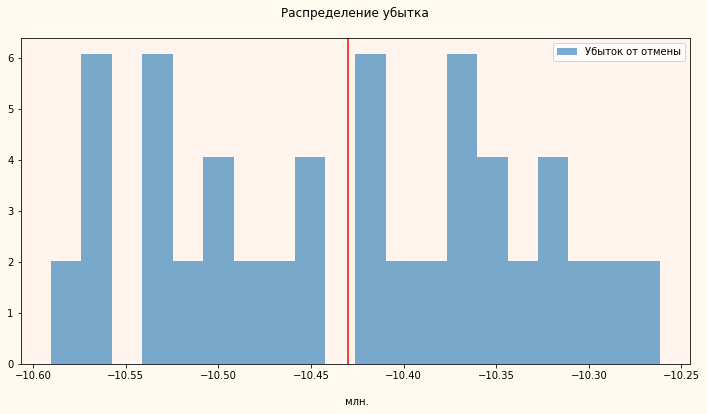

In [283]:
histogram(profit_unhappy, profit_mean_u, 'Суммарная прибыль', 'Распределение прибыли\n')
histogram(arrived_unhappy, arrived_mean_u, 'Прибыль от заехавших гостей', 'Распределение прибыли от заехавших гостей \n')
histogram(cancelled_unhappy, cancelled_mean_u, 'Убыток от отмены', 'Распределение убытка\n')

In [284]:
# Таблица
result = (
    pd.DataFrame([[profit_mean_u/10**6, arrived_mean_u/10**6, cancelled_mean_u/10**6], 
                  [profit_test_before/10**6, profit_arrived_test_before/10**6, loss_cancelled_test_before/10**6]],
    index=['После', 'До'], 
    columns=['Прибыль, млн.', 'Прибыль от заехавших гостей, млн.', 'Убыток от отменённых бронирований, млн.']
))
(result.
 style.
 format({'Прибыль, млн.':"{:,.2f}",'Прибыль от заехавших гостей, млн.':"{:,.2f}", 'Убыток от отменённых бронирований, млн.':"{:,.2f}"})
)

,"Прибыль, млн.","Прибыль от заехавших гостей, млн.","Убыток от отменённых бронирований, млн."
После,27.85,38.28,-10.43
До,33.93,53.04,-19.12


Как мы и ожидали, при такой реакции на нововведение прибыль будет меньше за счёт уменьшения прибыли от заехавших гостей. Кроме того, при таком раскладе нововведение уже не окупается и оказывается наоборот убыточным. 

Данный эксперимент показывает, насколько важно понимать, какие могут быть последствия от данного нововведения. Если действительно есть вероятность, что мы может потерять лояльных и благонадёжных клиентов, то тогда при выборе модели нам нужно ориентироваться не на recall, а на f1 метрику.

### Шаг 5. Опишите портрет «ненадёжного» клиента

Для описания портрета ненадёжного клиента мы посмотрим, на то, какие показатели увеличивают веротяность того, что человек отменит бронирование.

Восстановим наши фичи после препроцессора и их новые имена.

In [327]:
features_train_encoded = preprocessor.transform(features_train)
new_features_names = preprocessor.get_feature_names_out()

In [328]:
data_features_importance = (
    pd.DataFrame({'features_names':new_features_names,'feature_importance':best_model.feature_importances_}
))

In [329]:
data_features_importance = data_features_importance.sort_values('feature_importance', ascending=False).head(5)

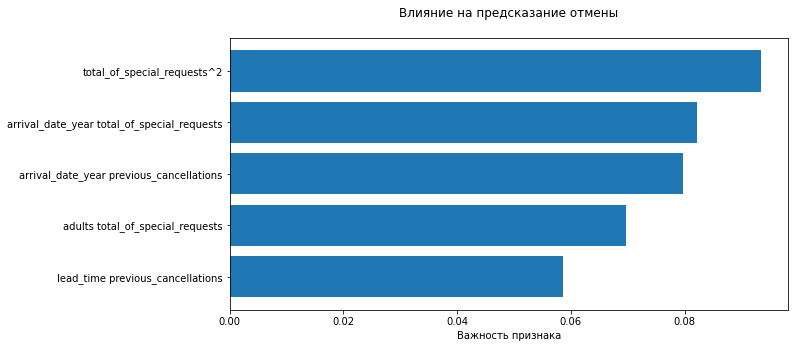

In [330]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
ax.barh(data_features_importance['features_names'], data_features_importance['feature_importance'] );
ax.invert_yaxis() 
ax.set_xlabel('Важность признака')
ax.set_title('Влияние на предсказание отмены\n');

Таким образом наша модель предсказывает, что типичный клиент склонный к отказу это клиент у которого много special requests, у которого ранее были отмены, особенно, если клиент с данными характеристиками бронирует номер очень заранее.

### Шаг 6. Напишите общий вывод

В данном проекте я исследовала перспективу введения новой функциональности в систему бронирования, которая будет определять, что клиент с большой долей вероятности может отменить бронирование и будет предлагать ему внести депозит.

У меня были данные о бронированиях изначально разделённые на обучающую и тестовую выборки. В данных не было пропусков, были дополнительные пробелы в категориальных переменных, которые я обработала. 

Я добавила в данные переменную о том, сколько номеров уже было занято на интересующий клиента период на момент бронирования.

Я создала функцию, которая подсчитывает прибыль отеля и показывает убыток от отменённых бронирований. Оказалось, что отель теряет практически половину прибыли из-за отмен бронирования. 

Далее, я посмотрела на переменные, которые на первой тестовой модели оказывают меньшее влияние на таргет, чем случайная величина и удалила эти показатели. 

Потом я провела поиск оптимальной комбинации из алгоритма балансировки классов и классификатора с помощью кросс-валидации. Оптимальной оказалась комбинация из оверсамплинга и модели дерева решений. На тестовой выборке модель показала рекол 0.63

После  этого я на тестовой выборке оценила прибыль, которую отель может получать, запрашивая депозиты у тех клиентов, которых модель определяет как склонных к отмене бронирования. Я оценила распределение прибыли после нововведения и оказалось, что за временной период тестовой выборки отель мог увеличить прибыль в среднем примерно на 9 млн., что окупает бюджет разработки и показывает, что депозиты нужно ввести.

Но если предположить, что в ответ на наше нововведение какие-то клиенты могут отказывать от сервиса, то тогда мы понесём убытки от того, что будем запрашивать депозиты. Если такой поворот событий возможен, то лучше оринтироваться на метрику f1 и наша модель уже не будет актуальной.

В последней части проекта я посмотрела на то, какие переменные наиболее влияют на то, что модель классифицирует клиента как склонного к отмене. Оказалось, что такой клиент это клиент с большим числом особых запросов, у которого ранее были отмены и который при этом делает бронь очень заранее. 